In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

import os
imgdir = 'output_images'
if not os.path.isdir(imgdir):
    os.mkdir(imgdir)

brands = ['Gummies', 'Sugar Buns', 'Sparkle Pop', 'Candys', 'Garlic Bombs', 'Snackmonds', 'Caffeinos', 'moon drops']
spend_types = ['Trade', 'Search', 'Display', 'TV', 'Radio']
num_brands, num_types = len(brands), len(spend_types)

In [2]:
np.random.seed(1)

In [3]:
import tqdm
try:
    tqdm_disp = tqdm.tqdm_notebook if get_ipython(
    ).__class__.__name__ == 'ZMQInteractiveShell' else tqdm.tqdm
except NameError:
    tqdm_disp = tqdm.tqdm

In [4]:
num_promos = 40000
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2018-06-01')
dates = pd.date_range(start_date, end_date)
num_dates = len(dates)

In [5]:
promo = pd.DataFrame(
    {'Brand':np.random.choice(brands, num_promos),
     'Type':np.random.choice(spend_types, num_promos), 
     'Spend':np.random.rand(num_promos) * 500,
     'date' : np.random.choice(dates, num_promos)})
promo = promo.groupby(['Brand', 'Type', 'date'])['Spend'].sum().to_frame()
promo = promo.unstack(fill_value=0).stack()
promo.shape

(35320, 1)

In [6]:
promo.iloc[np.random.choice(promo.shape[0], (promo.shape[0]*98)//100, replace=False)] = 0

In [7]:
initial_promo = promo.copy()

In [8]:
promo.shape, promo.rolling(40).mean().shape

((35320, 1), (35320, 1))

In [9]:
# for _ in range(10):
#     promo.iloc[10:] = promo.iloc[10:] + promo.iloc[:-10]

In [10]:

# promo = pd.concat([promo, initial_promo], axis=1).min(1).to_frame()
promo = promo.rolling(10).max().fillna(0)
promo = promo + np.expand_dims(np.random.rand(promo.shape[0]) * 20, 1)

In [11]:
assert(promo.shape[0] == num_brands * num_types * num_dates)

In [12]:
num_brands * num_types * num_dates

35320

In [13]:
true_baselines = {brand: [np.random.randn() * 100 + 1000] for brand in brands}

In [14]:
spend_rois = {t : [np.random.rand()+.8] for t in spend_types}
brand_rois = {t : [np.random.rand()/8] for t in brands}

In [15]:
brand_spend_combos = pd.DataFrame(
    data=np.random.rand(num_brands, num_types)*2 - .5, index=brands, columns = spend_types)

In [16]:
brand_spend_combos  = brand_spend_combos + \
    pd.DataFrame(brand_rois, index=spend_rois).T + pd.DataFrame(spend_rois, index = brands)

In [17]:
brand_spend_combos

,Trade,Search,Display,TV,Radio
Gummies,2.002109,2.391946,2.055097,3.147273,1.255852
Sugar Buns,0.839359,1.345147,1.177392,1.894680,1.033041
Sparkle Pop,2.520354,1.988653,1.334635,2.599975,1.973045
Candys,1.690016,2.002570,2.035602,2.557245,1.418665
Garlic Bombs,1.515791,2.087738,0.960900,2.664057,2.342928
Snackmonds,0.867707,2.289667,2.040395,2.217021,1.818233
Caffeinos,2.358605,1.608188,1.412806,1.689906,1.903828
moon drops,1.452903,2.135458,0.762418,2.495410,1.003424


In [18]:
promo2 = promo.unstack(1)

In [19]:
promo2.columns = promo2.columns.droplevel(0)
promo2 = promo2.reset_index(1)

In [20]:
effect = promo2.copy()
effect[effect.columns[1:]] = effect[effect.columns[1:]] * brand_spend_combos
effect = effect.reset_index().set_index(['Brand', 'date'])
effect = effect.sum(1).to_frame(name='spend').unstack(0)
effect.columns = effect.columns.droplevel(0)

In [21]:
effect.head()

Brand,Caffeinos,Candys,Garlic Bombs,Gummies,Snackmonds,Sparkle Pop,Sugar Buns,moon drops
date,,,,,,,,
2016-01-01,110.938175,99.005843,3046.578913,66.907568,98.791070,80.396571,61.484127,78.554356
2016-01-02,57.589317,118.009340,3048.370011,93.872998,108.433418,91.085044,50.175920,103.273542
2016-01-03,107.531391,90.132030,3097.988385,108.843947,124.185300,59.958085,73.086090,82.029770
2016-01-04,102.640621,147.894111,3069.840998,134.165543,98.479899,56.766046,85.798313,314.515900
2016-01-05,131.537208,87.857503,3089.968482,54.561957,77.648749,105.772278,78.723037,336.770660


In [22]:
salesnoise = pd.DataFrame(data = np.random.rand(num_dates, num_brands) * (-30), columns= brands, index=dates)
salesnoise.head()

,Gummies,Sugar Buns,Sparkle Pop,Candys,Garlic Bombs,Snackmonds,Caffeinos,moon drops
2016-01-01,-26.055594,-5.262947,-11.773256,-19.641696,-1.869418,-10.162017,-21.351608,-27.655961
2016-01-02,-17.105822,-25.585394,-17.514993,-12.855298,-0.378581,-29.094261,-27.711193,-3.466505
2016-01-03,-13.374861,-7.592778,-25.848567,-15.902208,-3.024488,-1.982246,-15.249565,-2.516850
2016-01-04,-23.485189,-20.798727,-0.436049,-9.702418,-20.794636,-2.065812,-19.004896,-9.525924
2016-01-05,-28.521287,-24.505317,-10.141417,-22.830015,-3.659542,-5.716049,-14.571160,-6.225739


In [23]:
seasonal_effects = pd.DataFrame(
    {brand: {'cos':np.random.randn() * 300, 'sin':np.random.randn()*300} for brand in brands})

In [24]:
seasonal_effects

,Gummies,Sugar Buns,Sparkle Pop,Candys,Garlic Bombs,Snackmonds,Caffeinos,moon drops
cos,-169.335809,-94.191682,-475.832887,-391.631527,-214.565008,112.885672,-260.849535,184.764160
sin,10.649195,-218.437284,367.680486,118.404713,596.901540,554.543320,-194.726173,-171.985174


In [25]:
seasonal_effects.T

,cos,sin
Gummies,-169.335809,10.649195
Sugar Buns,-94.191682,-218.437284
Sparkle Pop,-475.832887,367.680486
Candys,-391.631527,118.404713
Garlic Bombs,-214.565008,596.901540
Snackmonds,112.885672,554.543320
Caffeinos,-260.849535,-194.726173
moon drops,184.764160,-171.985174


In [26]:
brand_spend_combos

,Trade,Search,Display,TV,Radio
Gummies,2.002109,2.391946,2.055097,3.147273,1.255852
Sugar Buns,0.839359,1.345147,1.177392,1.894680,1.033041
Sparkle Pop,2.520354,1.988653,1.334635,2.599975,1.973045
Candys,1.690016,2.002570,2.035602,2.557245,1.418665
Garlic Bombs,1.515791,2.087738,0.960900,2.664057,2.342928
Snackmonds,0.867707,2.289667,2.040395,2.217021,1.818233
Caffeinos,2.358605,1.608188,1.412806,1.689906,1.903828
moon drops,1.452903,2.135458,0.762418,2.495410,1.003424


In [27]:
brand_spend_combos_with_seasonality = brand_spend_combos.join(seasonal_effects.T)

In [28]:
seasonal = salesnoise.index.dayofyear

seasonal_sine, seasonal_cos = np.sin(seasonal*2*np.pi/365), np.cos(seasonal*2*np.pi/365)

In [29]:
seasonal_effects = seasonal_effects[effect.columns]

In [30]:
seasonal_effects.loc[['cos'],:].values * np.expand_dims(seasonal_cos.values, 1)

array([[-260.81088726, -391.57350213, -214.53321752, ..., -475.76238726,
         -94.17772692,  184.73678525],
       [-260.69495569, -391.39944601, -214.43785658, ..., -475.55090882,
         -94.13586451,  184.65466895],
       [-260.50177458, -391.10940979, -214.27895307, ..., -475.19851439,
         -94.06610762,  184.51783548],
       ...,
       [ 221.08065557,  331.92374546,  181.8526246 , ...,  403.28784423,
          79.83130546, -156.59518673],
       [ 223.43092893,  335.4523741 ,  183.78587098, ...,  407.57513328,
          80.6799794 , -158.2599253 ],
       [ 225.71499488,  338.88160097,  185.66465765, ...,  411.74164902,
          81.50474611, -159.87776804]])

In [31]:
seasonal_effects.loc[['cos'],:]

,Caffeinos,Candys,Garlic Bombs,Gummies,Snackmonds,Sparkle Pop,Sugar Buns,moon drops
cos,-260.849535,-391.631527,-214.565008,-169.335809,112.885672,-475.832887,-94.191682,184.76416


In [32]:
seasonal_impact = seasonal_effects.loc[['cos'],:].values * np.expand_dims(seasonal_cos.values, 1) + \
    seasonal_effects.loc[['sin'],:].values * np.expand_dims(seasonal_sine.values, 1)

In [33]:
pd.DataFrame(true_baselines).iloc[0,:].std()

110.62131539204675

In [34]:
total_sales = effect + salesnoise + pd.DataFrame(true_baselines).iloc[0,:] + seasonal_impact

In [35]:
# total_sales = pd.DataFrame(
#     data=total_sales.values + np.expand_dims(sine.values, 1) + np.expand_dims(cos.values, 1),
#     index=total_sales.index, columns=total_sales.columns)

In [36]:
total_sales.head()

,Caffeinos,Candys,Garlic Bombs,Gummies,Snackmonds,Sparkle Pop,Sugar Buns,moon drops
date,,,,,,,,
2016-01-01,807.450655,591.753972,3838.611465,925.476210,1220.162214,363.245545,1097.334112,1176.598846
2016-01-02,744.507245,619.755462,3852.260395,961.649927,1220.364870,374.730899,1061.986396,1222.465807
2016-01-03,803.755216,591.157608,3909.657310,980.660389,1272.682233,341.946150,1099.202241,1199.077046
2016-01-04,792.033557,657.559929,3874.218590,996.230158,1256.304843,370.977600,1095.052792,1421.407411
2016-01-05,822.369402,586.949535,3922.011243,911.998817,1241.190356,417.222605,1080.647500,1443.764553


In [37]:
total_sales = total_sales.stack().to_frame(name='sales')

In [38]:
total_sales.head()

sales
date                                
2016-01-01 Caffeinos      807.450655
           Candys         591.753972
           Garlic Bombs  3838.611465
           Gummies        925.476210
           Snackmonds    1220.162214

In [39]:
promo_viewed = promo.unstack(1)
promo_viewed.columns = promo_viewed.columns.droplevel(0)
promo_viewed = promo_viewed.reset_index().sort_values('date').set_index(['date', 'Brand'])
promo_viewed.head(10)

Type                       Display       Radio      Search          TV  \
date       Brand                                                         
2016-01-01 Caffeinos     16.135259   14.690913    2.831179   10.361171   
           Snackmonds    14.160272   11.713946   13.184446    5.271207   
           Garlic Bombs  15.082936  490.655049  439.239679  358.579183   
           Sparkle Pop   11.788951   12.501283   11.123498    0.982495   
           Sugar Buns    15.927496   10.975427    8.207050    8.752944   
           Candys        17.723680   16.848329    7.227749    6.421023   
           moon drops    12.241247   11.396089    8.302899    6.923919   
           Gummies        0.981848   12.171804    2.409140    8.741358   
2016-01-02 moon drops     5.709591   10.711031    9.527136   17.292716   
           Snackmonds    18.230621   17.158762    6.862294    9.937763   

Type                         Trade  
date       Brand                    
2016-01-01 Caffeinos     16.158169  
           Snackmonds     7.750863  
           Garlic Bombs   6.744747  
           Sparkle Pop    6.079220  
           Sugar Buns     4.490846  
           Candys         4.811291  
           moon drops    15.677442  
           Gummies        8.156312  
2016-01-02 moon drops    16.983607  
           Snackmonds     2.642065

In [40]:
total_sales = total_sales - total_sales.min()
#total_sales = total_sales * 1000 / total_sales.max()

In [41]:
sales_viewed = total_sales.clip(0, np.inf)

In [42]:
data_viewed = promo_viewed.join(sales_viewed, on=['date', 'Brand'])

In [43]:
data_viewed.round(2).head(10)

Display   Radio  Search      TV  Trade    sales
date       Brand                                                        
2016-01-01 Caffeinos       16.14   14.69    2.83   10.36  16.16   621.34
           Snackmonds      14.16   11.71   13.18    5.27   7.75  1034.05
           Garlic Bombs    15.08  490.66  439.24  358.58   6.74  3652.50
           Sparkle Pop     11.79   12.50   11.12    0.98   6.08   177.13
           Sugar Buns      15.93   10.98    8.21    8.75   4.49   911.22
           Candys          17.72   16.85    7.23    6.42   4.81   405.64
           moon drops      12.24   11.40    8.30    6.92  15.68   990.49
           Gummies          0.98   12.17    2.41    8.74   8.16   739.36
2016-01-02 moon drops       5.71   10.71    9.53   17.29  16.98  1036.35
           Snackmonds      18.23   17.16    6.86    9.94   2.64  1034.25

In [44]:
sales_viewed.head(10)

sales
date                                
2016-01-01 Caffeinos      621.338224
           Candys         405.641541
           Garlic Bombs  3652.499034
           Gummies        739.363779
           Snackmonds    1034.049782
           Sparkle Pop    177.133114
           Sugar Buns     911.221681
           moon drops     990.486415
2016-01-02 Caffeinos      558.394814
           Candys         433.643030

In [45]:
spend = data_viewed.drop('sales', 1)
Yraw = data_viewed[['sales']]
spend.head(10)

Display       Radio      Search          TV  \
date       Brand                                                         
2016-01-01 Caffeinos     16.135259   14.690913    2.831179   10.361171   
           Snackmonds    14.160272   11.713946   13.184446    5.271207   
           Garlic Bombs  15.082936  490.655049  439.239679  358.579183   
           Sparkle Pop   11.788951   12.501283   11.123498    0.982495   
           Sugar Buns    15.927496   10.975427    8.207050    8.752944   
           Candys        17.723680   16.848329    7.227749    6.421023   
           moon drops    12.241247   11.396089    8.302899    6.923919   
           Gummies        0.981848   12.171804    2.409140    8.741358   
2016-01-02 moon drops     5.709591   10.711031    9.527136   17.292716   
           Snackmonds    18.230621   17.158762    6.862294    9.937763   

                             Trade  
date       Brand                    
2016-01-01 Caffeinos     16.158169  
           Snackmonds     7.750863  
           Garlic Bombs   6.744747  
           Sparkle Pop    6.079220  
           Sugar Buns     4.490846  
           Candys         4.811291  
           moon drops    15.677442  
           Gummies        8.156312  
2016-01-02 moon drops    16.983607  
           Snackmonds     2.642065

In [46]:
seasonal_X = spend.reset_index()['date'].dt.dayofyear

sine_X, cos_X = np.sin(seasonal_X*2*np.pi/365), np.cos(seasonal_X*2*np.pi/365)
#sine_X = sine_X.to_frame('sine')
#cos_X = cos_X.to_frame('cos')

In [47]:
dummies = pd.get_dummies(spend.reset_index()['Brand'])
dummies = dummies.set_index(spend.index)

In [48]:

spend['cos'] = cos_X.values
spend['sin'] = sine_X.values

In [49]:
spend.reset_index().groupby('date')[['cos', 'sin']].max().head(10)

,cos,sin
date,,
2016-01-01,0.999852,0.017213
2016-01-02,0.999407,0.034422
2016-01-03,0.998667,0.051620
2016-01-04,0.997630,0.068802
2016-01-05,0.996298,0.085965
2016-01-06,0.994671,0.103102
2016-01-07,0.992749,0.120208
2016-01-08,0.990532,0.137279
2016-01-09,0.988023,0.154309


In [50]:
spend.reset_index().set_index('date')['Brand'].to_frame().head()

,Brand
date,
2016-01-01,Caffeinos
2016-01-01,Snackmonds
2016-01-01,Garlic Bombs
2016-01-01,Sparkle Pop
2016-01-01,Sugar Buns


In [51]:
def color_background(val):
    color = '' if val < 1 else 'lightgreen'
    return 'background-color: ' + color
def color_number(val):
    color = 'red' if val < 1 else ''
    return 'color: %s' % color

In [52]:
dummies.head().style.applymap(color_background).applymap(color_number)

In [53]:
dummies.head()

Caffeinos  Candys  Garlic Bombs  Gummies  Snackmonds  \
date       Brand                                                                
2016-01-01 Caffeinos             1       0             0        0           0   
           Snackmonds            0       0             0        0           1   
           Garlic Bombs          0       0             1        0           0   
           Sparkle Pop           0       0             0        0           0   
           Sugar Buns            0       0             0        0           0   

                         Sparkle Pop  Sugar Buns  moon drops  
date       Brand                                              
2016-01-01 Caffeinos               0           0           0  
           Snackmonds              0           0           0  
           Garlic Bombs            0           0           0  
           Sparkle Pop             1           0           0  
           Sugar Buns              0           1           0

In [54]:
dummy_spends = {}
for dummy in dummies.columns:
    brand_spend = pd.DataFrame(
        dummies[dummy].to_frame().values * spend.values, 
        index=spend.index, columns=['type:' + c + '_brand:' + dummy for c in spend.columns])
    dummy_spends[dummy] = brand_spend

In [55]:
Xraw = pd.concat((spend, dummies, *list(dummy_spends.values())), 1)

In [56]:
Xraw.head(10).tail(5).round()

Display  Radio  Search    TV  Trade  cos  sin  \
date       Brand                                                       
2016-01-01 Candys         18.0   17.0     7.0   6.0    5.0  1.0  0.0   
           moon drops     12.0   11.0     8.0   7.0   16.0  1.0  0.0   
           Gummies         1.0   12.0     2.0   9.0    8.0  1.0  0.0   
2016-01-02 moon drops      6.0   11.0    10.0  17.0   17.0  1.0  0.0   
           Snackmonds     18.0   17.0     7.0  10.0    3.0  1.0  0.0   

                       Caffeinos  Candys  Garlic Bombs  \
date       Brand                                         
2016-01-01 Candys              0       1             0   
           moon drops          0       0             0   
           Gummies             0       0             0   
2016-01-02 moon drops          0       0             0   
           Snackmonds          0       0             0   

                                 ...              type:Trade_brand:Sugar Buns  \
date       Brand                 ...                                            
2016-01-01 Candys                ...                                      0.0   
           moon drops            ...                                      0.0   
           Gummies               ...                                      0.0   
2016-01-02 moon drops            ...                                      0.0   
           Snackmonds            ...                                      0.0   

                       type:cos_brand:Sugar Buns  type:sin_brand:Sugar Buns  \
date       Brand                                                              
2016-01-01 Candys                            0.0                        0.0   
           moon drops                        0.0                        0.0   
           Gummies                           0.0                        0.0   
2016-01-02 moon drops                        0.0                        0.0   
           Snackmonds                        0.0                        0.0   

                       type:Display_brand:moon drops  \
date       Brand                                       
2016-01-01 Candys                                0.0   
           moon drops                           12.0   
           Gummies                               0.0   
2016-01-02 moon drops                            6.0   
           Snackmonds                            0.0   

                       type:Radio_brand:moon drops  \
date       Brand                                     
2016-01-01 Candys                              0.0   
           moon drops                         11.0   
           Gummies                             0.0   
2016-01-02 moon drops                         11.0   
           Snackmonds                          0.0   

                       type:Search_brand:moon drops  type:TV_brand:moon drops  \
date       Brand                                                                
2016-01-01 Candys                               0.0                       0.0   
           moon drops                           8.0                       7.0   
           Gummies                              0.0                       0.0   
2016-01-02 moon drops                          10.0                      17.0   
           Snackmonds                           0.0                       0.0   

                       type:Trade_brand:moon drops  type:cos_brand:moon drops  \
date       Brand                                                                
2016-01-01 Candys                              0.0                        0.0   
           moon drops                         16.0                        1.0   
           Gummies                             0.0                        0.0   
2016-01-02 moon drops                         17.0                        1.0   
           Snackmonds                          0.0                        0.0   

                       type:sin_brand:moon drops  
date       Brand              

In [57]:
xmeans, xstds = Xraw.mean(), Xraw.std()
ymeans, ystds = Yraw.mean(), Yraw.std()

In [58]:
xstds[spend.columns] = xstds[spend.columns] / 10
for col in xstds.index:
    if 'sin_' in col or 'cos_' in col:
        xstds[col] = xstds[col] / 10


In [59]:
xstds[brands] = xstds[brands] / 100

In [60]:
X = (Xraw - xmeans) / xstds
Y = (Yraw - ymeans)/ystds

In [61]:
X.round(2).head()

Display  Radio  Search     TV  Trade    cos  sin  \
date       Brand                                                            
2016-01-01 Caffeinos       -2.78  -2.66   -3.74  -2.82  -2.61  13.88 -1.5   
           Snackmonds      -2.90  -2.85   -3.15  -3.11  -3.09  13.88 -1.5   
           Garlic Bombs    -2.84  26.97   21.27  17.52  -3.15  13.88 -1.5   
           Sparkle Pop     -3.03  -2.80   -3.27  -3.36  -3.18  13.88 -1.5   
           Sugar Buns      -2.79  -2.89   -3.43  -2.91  -3.27  13.88 -1.5   

                         Caffeinos  Candys  Garlic Bombs  \
date       Brand                                           
2016-01-01 Caffeinos        264.56  -37.79        -37.79   
           Snackmonds       -37.79  -37.79        -37.79   
           Garlic Bombs     -37.79  -37.79        264.56   
           Sparkle Pop      -37.79  -37.79        -37.79   
           Sugar Buns       -37.79  -37.79        -37.79   

                                   ...              \
date       Brand                   ...               
2016-01-01 Caffeinos               ...               
           Snackmonds              ...               
           Garlic Bombs            ...               
           Sparkle Pop             ...               
           Sugar Buns              ...               

                         type:Trade_brand:Sugar Buns  \
date       Brand                                       
2016-01-01 Caffeinos                           -0.09   
           Snackmonds                          -0.09   
           Garlic Bombs                        -0.09   
           Sparkle Pop                         -0.09   
           Sugar Buns                          -0.01   

                         type:cos_brand:Sugar Buns  type:sin_brand:Sugar Buns  \
date       Brand                                                                
2016-01-01 Caffeinos                         -0.17                      -0.61   
           Snackmonds                        -0.17                      -0.61   
           Garlic Bombs                      -0.17                      -0.61   
           Sparkle Pop                       -0.17                      -0.61   
           Sugar Buns                        40.39                       0.07   

                         type:Display_brand:moon drops  \
date       Brand                                         
2016-01-01 Caffeinos                             -0.13   
           Snackmonds                            -0.13   
           Garlic Bombs                          -0.13   
           Sparkle Pop                           -0.13   
           Sugar Buns                            -0.13   

                         type:Radio_brand:moon drops  \
date       Brand                                       
2016-01-01 Caffeinos                           -0.13   
           Snackmonds                          -0.13   
           Garlic Bombs                        -0.13   
           Sparkle Pop                         -0.13   
           Sugar Buns                          -0.13   

                         type:Search_brand:moon drops  \
date       Brand                                        
2016-01-01 Caffeinos                            -0.13   
           Snackmonds                           -0.13   
           Garlic Bombs                         -0.13   
           Sparkle Pop                          -0.13   
           Sugar Buns                           -0.13   

                         type:TV_brand:moon drops  \
date       Brand                                    
2016-01-01 Caffeinos                         -0.1   
           Snackmonds                        -0.1   
           Garlic Bombs                      -0.1   
           Sparkle Pop                       -0.1   
           Sugar Buns                        -0.1   

                         type:Trade_brand:moon drops  \
date       Brand                                       
2016-01-01 Caffeinos                    

In [62]:
clf = Ridge(1e-5).fit(X, Y)

In [63]:
import tensorflow as tf
lr = tf.placeholder(tf.float32, ())
x_in = tf.placeholder(tf.float32, (None, X.shape[1]))
y_in = tf.placeholder(tf.float32, (None))
w = tf.Variable(np.random.randn(X.shape[1]), dtype=tf.float32)
b = tf.Variable(0, dtype=tf.float32)
yhat = tf.reduce_sum(x_in * tf.expand_dims(w, 0)) + b
loss = tf.reduce_mean(tf.square(y_in-yhat)) + 1e-15 * (tf.reduce_sum(tf.square(w)))

C:\Users\leedt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [64]:
# optim = tf.train.AdamOptimizer(lr).minimize(loss)

# feed_dict = {
#     x_in:X, y_in:Y
# }

# s = tf.Session()
# s.run(tf.global_variables_initializer())
# for i in range(1000):
#     feed_dict[lr] = 1e0/np.sqrt(i+1)
#     l, _ = s.run([loss, optim], feed_dict)
#     if i % 100 == 0:
#         print(l)

In [65]:
# optim = tf.contrib.opt.ScipyOptimizerInterface(
#         loss, tol=0
#     )
# feed_dict = {
#     x_in:X, y_in:Y
# }

# s = tf.Session()
# s.run(tf.global_variables_initializer())

# with tqdm_disp() as tq:
#     y_hat_trace = []

#     def loss_callback(y_hat, loss):
#         y_hat_trace.append(y_hat)
#         tq.update()
#         tq.set_postfix_str('loss = %.6f' % (loss))

#     optim.minimize(
#         s,
#         feed_dict=feed_dict,
#         fetches=[yhat, loss],
#         loss_callback=loss_callback,
#     )
#     y_hat = y_hat_trace[-1]

In [66]:
#s.run(loss, feed_dict)

In [67]:
#coef_tf = s.run(w)

In [68]:
clf.coef_

array([[ 2.98546470e-02,  3.29249722e-02,  4.19585730e-02,
         5.43379544e-02,  3.75365526e-02, -7.36579271e-03,
         6.15356722e-03,  3.66371986e-05, -3.04826344e-04,
         1.06152756e-04,  3.41974535e-04,  1.52740179e-04,
        -8.95142899e-04,  7.07010625e-04, -1.26014474e-04,
         3.36861688e-03,  1.99309062e-02, -2.15815734e-02,
        -5.24647387e-02,  2.89339124e-02, -5.70251332e-03,
        -8.58402499e-03,  4.70948056e-02, -1.44460075e-02,
         1.22836214e-02,  9.17292820e-03,  2.68012477e-03,
        -9.87149083e-03,  1.66318090e-03, -3.90059243e-02,
         6.91431005e-02,  1.91548237e-02,  1.85684412e-02,
        -1.34926725e-02, -4.23550114e-03,  1.73203923e-02,
         3.92237190e-02, -2.80725268e-02,  3.03099186e-02,
         5.63180487e-02,  4.63963527e-02, -2.78248571e-03,
        -1.84948311e-03,  6.96563868e-02,  1.41164596e-02,
         4.06652639e-02, -1.79753051e-02, -4.87669318e-02,
         6.20468110e-03,  1.59309739e-02, -3.62069510e-0

In [69]:
coef = clf.coef_ / xstds.values * ystds.values
#coef = (np.expand_dims(coef_tf, 0) / xstds.values) * ystds.values

In [70]:
display = pd.DataFrame(coef, columns=X.columns)

In [71]:
aggregated = spend.columns
bias = dummies.columns
deltas = np.array([col for col in X.columns if col not in aggregated and col not in bias])

In [72]:
results = pd.DataFrame(
    data=np.zeros((num_brands+1, spend.columns.shape[0]+1)), 
    index=['aggregated'] + brands, columns = ['bias'] + list(spend.columns))

In [73]:
results

,bias,Display,Radio,Search,TV,Trade,cos,sin
aggregated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gummies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sugar Buns,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sparkle Pop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Candys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Garlic Bombs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Snackmonds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Caffeinos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
moon drops,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
results.loc[['aggregated'], aggregated]


,Display,Radio,Search,TV,Trade,cos,sin
aggregated,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
display[aggregated]

,Display,Radio,Search,TV,Trade,cos,sin
0,1.343525,1.585991,1.860872,2.455198,1.663727,-81.823658,67.415983


In [76]:
display

,Display,Radio,Search,TV,Trade,cos,sin,Caffeinos,Candys,Garlic Bombs,...,type:Trade_brand:Sugar Buns,type:cos_brand:Sugar Buns,type:sin_brand:Sugar Buns,type:Display_brand:moon drops,type:Radio_brand:moon drops,type:Search_brand:moon drops,type:TV_brand:moon drops,type:Trade_brand:moon drops,type:cos_brand:moon drops,type:sin_brand:moon drops
0,1.343525,1.585991,1.860872,2.455198,1.663727,-81.823658,67.415983,8.570828,-71.310424,24.833149,...,-0.82331,-11.622309,-284.788063,-0.582029,-0.582432,0.274273,0.040172,-0.21136,266.97055,-238.860741


In [77]:
display['type:Display_brand:Gummies']

0    0.714502
Name: type:Display_brand:Gummies, dtype: float64

In [78]:
results.loc[['aggregated'], aggregated] = display[aggregated].values
for brand in brands:
    results.loc[brand, 'bias'] = display[brand].values
    results.loc[brand, aggregated] = display.loc[:,[b for b in deltas if brand in b]].values + display[aggregated].values

In [79]:
results

,bias,Display,Radio,Search,TV,Trade,cos,sin
aggregated,0.000000,1.343525,1.585991,1.860872,2.455198,1.663727,-81.823658,67.415983
Gummies,80.000793,2.058027,1.259020,2.385768,3.144535,2.003617,-169.162987,10.851879
Sugar Buns,165.396556,1.178763,1.032960,1.345340,1.894795,0.840417,-93.445967,-217.372080
Sparkle Pop,-209.407819,1.338354,1.971463,1.989502,2.599572,2.519135,-476.073785,367.636816
Candys,-71.310424,2.034833,1.415462,2.003654,2.555801,1.692935,-391.679478,118.282270
Garlic Bombs,24.833149,0.960806,2.343238,2.086772,2.664468,1.514268,-214.771629,597.138299
Snackmonds,35.731711,2.040591,1.818709,2.289473,2.215620,0.869744,112.934822,554.644694
Caffeinos,8.570828,1.410404,1.902031,1.610664,1.689683,2.359478,-260.819614,-195.115577
moon drops,-29.479557,0.761495,1.003559,2.135145,2.495371,1.452366,185.146893,-171.444758


In [80]:
import calendar

In [81]:
def add_month(df):
    df = df.copy()

    df['phase'] = np.angle((
            df['sin'] * 1j + df['cos']).astype(complex))
    df['peak_month'] = ((
            (df['phase'] * 12 / 2 / np.pi)) % 12).round().astype(int)
    df.loc[df['peak_month'] == 0, 'peak_month'] = 12
    df['peak_month'] = df['peak_month'].apply(
        lambda x: calendar.month_abbr[x])
    df['seasonal_impact'] = np.sqrt(
        (np.square(df['sin']) + np.square(
            df['cos'])).astype('float'))
    df['seasonal_impact'] = (df[
        'seasonal_impact'] - df['seasonal_impact'].min()) / df['seasonal_impact'].std() + 0.1
    return df

In [82]:
groundtruth = add_month(brand_spend_combos_with_seasonality)
results2 = add_month(results)

In [83]:
groundtruth[list(aggregated) + ['peak_month', 'seasonal_impact']].round(2)

,Display,Radio,Search,TV,Trade,cos,sin,peak_month,seasonal_impact
Gummies,2.06,1.26,2.39,3.15,2.00,-169.34,10.65,Jun,0.10
Sugar Buns,1.18,1.03,1.35,1.89,0.84,-94.19,-218.44,Aug,0.48
Sparkle Pop,1.33,1.97,1.99,2.60,2.52,-475.83,367.68,May,2.48
Candys,2.04,1.42,2.00,2.56,1.69,-391.63,118.40,May,1.42
Garlic Bombs,0.96,2.34,2.09,2.66,1.52,-214.57,596.90,Apr,2.66
Snackmonds,2.04,1.82,2.29,2.22,0.87,112.89,554.54,Mar,2.29
Caffeinos,1.41,1.90,1.61,1.69,2.36,-260.85,-194.73,Jul,0.96
moon drops,0.76,1.00,2.14,2.50,1.45,184.76,-171.99,Nov,0.56


In [84]:
display[[col for col in display.columns if 'sin' in col and 'Cand' in col]]

,type:sin_brand:Candys
0,50.866287


In [85]:
results2[list(aggregated) + ['peak_month', 'seasonal_impact']].round(2)

,Display,Radio,Search,TV,Trade,cos,sin,peak_month,seasonal_impact
aggregated,1.34,1.59,1.86,2.46,1.66,-81.82,67.42,May,0.10
Gummies,2.06,1.26,2.39,3.14,2.00,-169.16,10.85,Jun,0.42
Sugar Buns,1.18,1.03,1.35,1.89,0.84,-93.45,-217.37,Aug,0.77
Sparkle Pop,1.34,1.97,1.99,2.60,2.52,-476.07,367.64,May,2.63
Candys,2.03,1.42,2.00,2.56,1.69,-391.68,118.28,May,1.65
Garlic Bombs,0.96,2.34,2.09,2.66,1.51,-214.77,597.14,Apr,2.80
Snackmonds,2.04,1.82,2.29,2.22,0.87,112.93,554.64,Mar,2.45
Caffeinos,1.41,1.90,1.61,1.69,2.36,-260.82,-195.12,Jul,1.22
moon drops,0.76,1.00,2.14,2.50,1.45,185.15,-171.44,Nov,0.85


In [86]:
display_aggregated = display.rename({col: 'aggregated:'+col for col in spend.columns}, axis=1)

In [87]:
display_aggregated

,aggregated:Display,aggregated:Radio,aggregated:Search,aggregated:TV,aggregated:Trade,aggregated:cos,aggregated:sin,Caffeinos,Candys,Garlic Bombs,...,type:Trade_brand:Sugar Buns,type:cos_brand:Sugar Buns,type:sin_brand:Sugar Buns,type:Display_brand:moon drops,type:Radio_brand:moon drops,type:Search_brand:moon drops,type:TV_brand:moon drops,type:Trade_brand:moon drops,type:cos_brand:moon drops,type:sin_brand:moon drops
0,1.343525,1.585991,1.860872,2.455198,1.663727,-81.823658,67.415983,8.570828,-71.310424,24.833149,...,-0.82331,-11.622309,-284.788063,-0.582029,-0.582432,0.274273,0.040172,-0.21136,266.97055,-238.860741


In [88]:
X.columns.shape

(71,)

In [89]:
data_viewed.head()

Display       Radio      Search          TV  \
date       Brand                                                         
2016-01-01 Caffeinos     16.135259   14.690913    2.831179   10.361171   
           Snackmonds    14.160272   11.713946   13.184446    5.271207   
           Garlic Bombs  15.082936  490.655049  439.239679  358.579183   
           Sparkle Pop   11.788951   12.501283   11.123498    0.982495   
           Sugar Buns    15.927496   10.975427    8.207050    8.752944   

                             Trade        sales  
date       Brand                                 
2016-01-01 Caffeinos     16.158169   621.338224  
           Snackmonds     7.750863  1034.049782  
           Garlic Bombs   6.744747  3652.499034  
           Sparkle Pop    6.079220   177.133114  
           Sugar Buns     4.490846   911.221681

In [90]:
from scipy.ndimage.filters import gaussian_filter

In [95]:
def view_brand(df, b):
    plt.figure(figsize=(15, 10))
    brand = data_viewed.query('Brand == "' + b + '"')
    x = brand.reset_index()['date']
    for spend in ['Display', 'TV', 'sales']:#brand.columns:
        vals = brand[spend]
        vals = gaussian_filter(vals, 8)
        vals = vals + np.random.rand(vals.shape[0]) * 30
#         vals = vals - vals.min()
#         vals = vals/vals.max()
        if spend in results2.columns:
            lbl = spend + ' Regression Coef: ' + str(results2.loc[b, spend].round(2))
        else:
            lbl = spend
        plt.plot(x, vals, label=lbl)
    sin = np.sin(x.dt.dayofyear * 2 * np.pi/365)
    cos = np.cos(x.dt.dayofyear * 2 * np.pi/365)
    sin, cos = sin * 100, cos * 100
#     sin, cos = sin - sin.min(), cos - cos.min()
#     sin, cos = sin/sin.max(), cos/cos.max()
    plt.plot(x, sin, label='sine')
    plt.plot(x, cos, label='cos')
    plt.legend()
    plt.title('Visualization For ' + b)
    plt.show()


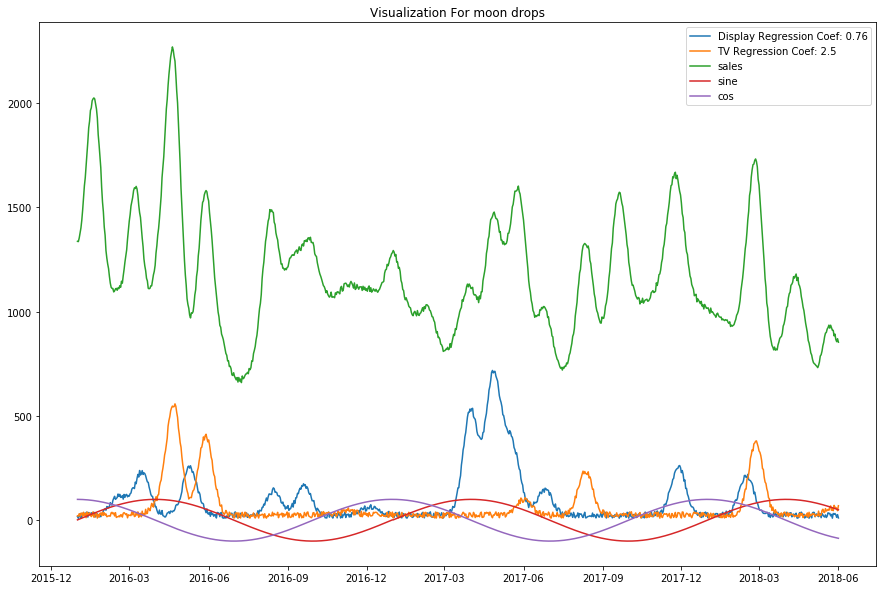

In [96]:
view_brand(data_viewed, 'moon drops')